# Final Model

In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.append(str(project_root))

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_predict

# sklearn models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# imblearn
from imblearn.pipeline import Pipeline as ImbalancePipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# lightgbm
from lightgbm import LGBMClassifier

# project
from src.preprocess import preprocess_data

In [3]:
train = pd.read_parquet('../data/train.parquet')
sample_train = train.groupby('isFraud', group_keys=False)[train.columns].apply(lambda x: x.sample(frac=0.1, random_state=42))

print(train.shape)
print(sample_train.shape)

(590540, 450)
(59054, 450)


In [4]:
X = sample_train.drop(columns=['isFraud'])
y = sample_train['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(X_train.shape)
print(y_train.shape)

del train, sample_train

(41337, 449)
(41337,)


In [5]:
X_train_transformed, X_test_transformed = preprocess_data(X_train, X_test)

In [6]:
del X_train, X_test

## SMOTE + LightGBM

In [ ]:
clf = LGBMClassifier(random_state=42)
smote = SMOTE(sampling_strategy='minority', random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test_transformed)

[LightGBM] [Info] Number of positive: 39891, number of negative: 39891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50714
[LightGBM] [Info] Number of data points in the train set: 79782, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [8]:
confusion_matrix(y_test, y_pred)

array([[17051,    46],
       [  398,   222]])

In [9]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9749393238132866
Precision: 0.8283582089552238
Recall: 0.3580645161290323
F1 Score: 0.5


In [10]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')

ROC AUC: 0.6776869928133026


## UnderBagging

In [14]:
clf = RandomForestClassifier(random_state=42)
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test_transformed)

In [15]:
confusion_matrix(y_test, y_pred)

array([[13281,  3816],
       [  152,   468]])

In [16]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.7760343173223457
Precision: 0.1092436974789916
Recall: 0.7548387096774194
F1 Score: 0.19086460032626426


In [17]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')

ROC AUC: 0.7658208287815067


## GridSearch

In [177]:
k_folds = 5

param_grid = {
    'n_estimators': [100], # quanto maior melhor
    'max_depth': [50, 60, 75]
}

clf = RandomForestClassifier(random_state=42, n_jobs=8)
cv = StratifiedKFold(n_splits=k_folds, shuffle=True)

In [178]:
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc')
grid_search.fit(X_train_res, y_train_res)

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.862492674772275
{'max_depth': 50, 'n_estimators': 100}
RandomForestClassifier(max_depth=50, n_jobs=8, random_state=42)


## Threshold

In [144]:
y_scores = cross_val_predict(clf, X_train_res, y_train_res, cv=cv, method='predict_proba')

y_scores

array([[0.58, 0.42],
       [0.87, 0.13],
       [0.83, 0.17],
       ...,
       [0.08, 0.92],
       [0.35, 0.65],
       [0.59, 0.41]])

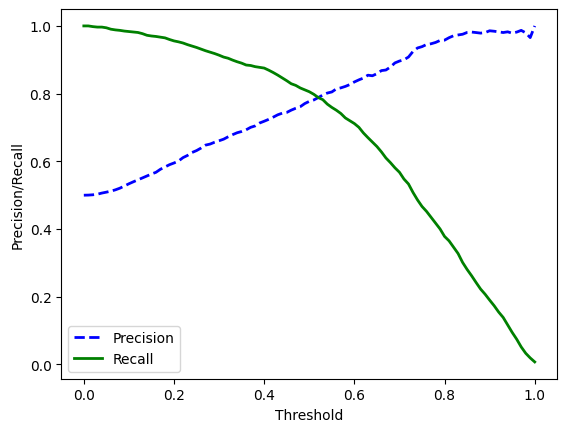

In [145]:
precision, recall, threshold = precision_recall_curve(y_train_res, y_scores[:, 1])

plt.plot(threshold, precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(threshold, recall[:-1], "g-", label="Recall", linewidth=2)

plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend(loc="lower left")

plt.show()

In [146]:
print(f'Target threshold to obtain 90% precision is {threshold[np.argmax(precision >= 0.90)]}')
print(f'Target threshold to obtain 90% precision is {threshold[np.argmin(recall >= 0.90)]}')

Target threshold to obtain 90% precision is 0.71
Target threshold to obtain 90% precision is 0.33


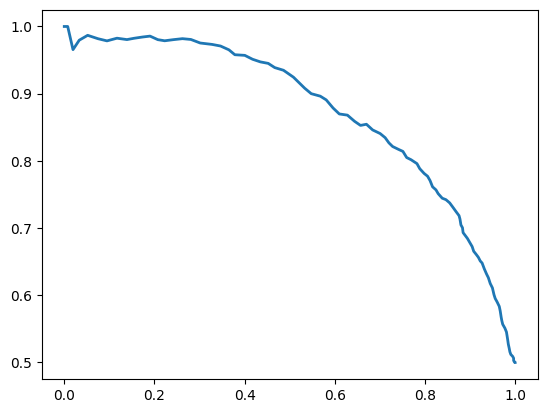

In [147]:
plt.plot(recall, precision, linewidth=2, label="Precision/Recall curve")

In [148]:
print(threshold[np.argmax(precision >= 0.90)])
print(threshold[np.argmin(recall >= 0.90)])

0.71
0.33


In [168]:
target_threshold = 0.51

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

y_scores = clf.predict_proba(X_test_transformed)[:, 1]
y_pred = (y_scores >= target_threshold).astype(int)

In [169]:
confusion_matrix(y_test, y_pred)

array([[13281,  3816],
       [  152,   468]])

In [170]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.7760343173223457
Precision: 0.1092436974789916
Recall: 0.7548387096774194
F1 Score: 0.19086460032626426


In [171]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')

ROC AUC: 0.7658208287815067
